# Реранжирование в рекомендациях с помощью GDBT

## Домашнее задание
**Обучить двухэтапную модель и добавить ее в сервис**

Нужно, ипользуя датасет [киона](https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip), взять одну или несколько моделей с прошлых лекций, обучить ранкер на их предсказаниях и добавить все как отдельный endpoint в сервис **(20 баллов)**

Исследования:
- Подготовить юпитер-ноутбук с обучением ранкера **(6 баллов)**:
    - подготовил датасет с лучшей моделью (LightFM) и популярным;
    - обучили ранкер (даже два, листвайс и паирвайс);
    - сравнили метрик двухэтапной модели и моделей первого уровня на тестовой выборке  (паирвайз лучше всех, его и использовали)
- Ранкер умеет работать с холодными пользователями **(4 балла)**:
    - на первом уровне, одна из моделей - популярное, модель для холодного старта (например популярное из лекции 3)
    - всего на первом уровне не менее двух моделей (LightFM и Популярное).
    - среди признаков ранкера есть хотя бы один, определяющий холодность пользователя (длина истории просмотров, общее время просмотра - это было на практике, труда не составило применить здесь).
- Разные библиотеки не сравнивал, но сравнил ListWise и Pairwise из библиотеки XGBRanker **(2 балла)**:
    - `ndcg@10`: for lfm - 0.031383, for pointwise - 0.030071, 	0.037817

Сервис
- Добавить в сервис endpoint с двухэтапной моделью (офлайн или онлайн). Появиться на лидерборде с двухэтапной моделью **(6 баллов)**:
    - сделал, в бот отправил
- К сожалению, наилучший скор был у LightFM (`0.09878423`), а у модели из этого дз: `0.0944343`  oh-oh.... Не знаю, почему так)))

## Импорты

In [1]:
import warnings
import gc

from typing import List

from copy import deepcopy

warnings.simplefilter("ignore")

import pickle
import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.dataset import Dataset
from rectools.models import PopularModel, RandomModel, ImplicitALSWrapperModel, LightFMWrapperModel
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile


from dev_eval import calculate_metrics, read_kion_dataset, visualize
from tools import avg_user_metric, generate_lightfm_recs_mapper, calc_metrics_

models_metrics: Dict[str, Dict[str, float]] = dict()

## Подготовка данных

Все те же данные:)

Предобработка -- по большей части с семинара

In [3]:
interactions = pd.read_csv("../data/data_original/interactions.csv")
users = pd.read_csv("../data/data_original/users.csv")
items = pd.read_csv("../data/data_original/items.csv")

### `interactions`: взаимодействия пользователь - айтем 
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [4]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [5]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        "last_watch_dt": Columns.Datetime,
        "watched_pct": Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions["datetime"] = interactions["datetime"].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
    Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.0,
    "total_dur": 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(3)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


### `users`: данные о пользователях

- `age` бин по возрасту 
- `income` бин по доходу 
- `sex` пол 
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [6]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [7]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


users_cat_cols = [
    # 'user_id',
    "age",
    "income",
    "sex",
    "kids_flg",
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding["income"], users["income"].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [8]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [9]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [10]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    "content_type",
    "for_kids",
    "studios",
]
items_text_cols = [
    "title",
    "title_orig",
    "genres",
    "countries",
    "directors",
    "actors",
    "description",
    "keywords",
]
items_num_cols = [
    "release_year",
    "age_rating",
]
default_values_items = {
    "release_year": items["release_year"].median(),
    "age_rating": items["age_rating"].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding["studios"]

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [11]:
items.describe(include="all")

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит
Опять  же, с семинара -- так как надо поделить, чтобы не было лика данных в двуступенчатой модели.!

In [12]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")
print(f"Продолжительность: {max_date - min_date}")

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам (удобна для первого запуска в  проде)

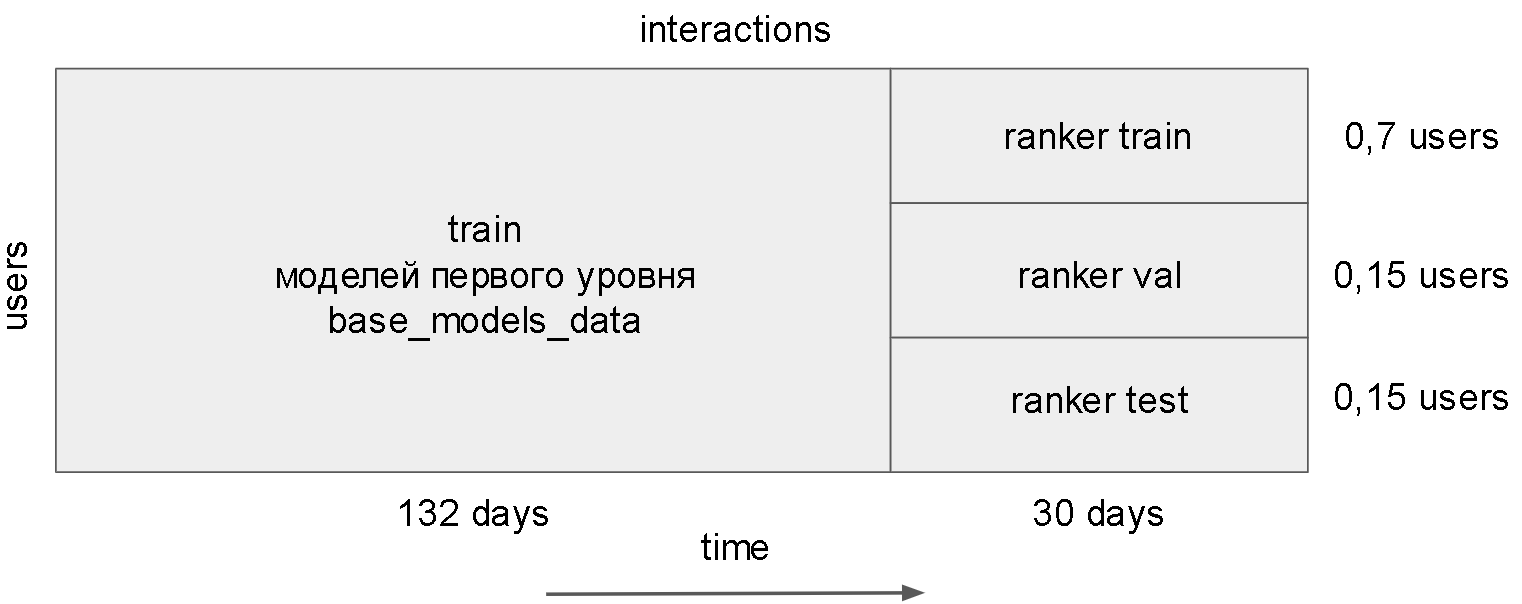

In [13]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[(interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(ranker_data["user_id"].unique(), random_state=42, test_size=test_size)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [14]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[(interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))]

## Обучаем модель первого уровня

Будем использовать необходимые кусочки кода из прошлых дз для конструирования датасета и моделей LightFM и Popular. 

In [14]:
from itertools import product


def is_dict(var):
    return isinstance(var, dict)


def create_models_dict(param_dict: dict, name_template: str, ModelClass):
    # this needed in case value of dict is another dict (e.g. dict of models)
    param_keys_dict = dict()
    param_values_dict = dict()

    for item in param_dict:
        param_keys_dict[item] = param_dict[item]
        param_values_dict[item] = param_dict[item]
        if is_dict(param_dict[item]):
            param_keys_dict[item] = list(param_dict[item].keys())
            param_values_dict[item] = list(param_dict[item].values())

    models_dict = {}

    # Extract keys and values from initial dict of parameters
    keys = list(param_dict.keys())
    values = [param_values_dict[key] for key in keys]
    values_names = [param_keys_dict[key] for key in keys]

    value_combinations = product(*values)
    name_combinations = product(*values_names)

    # Generate all combinations of parameter values
    for value_combination, name_combination in zip(value_combinations, name_combinations):
        param_names = dict(zip(keys, name_combination))
        params = deepcopy(dict(zip(keys, value_combination)))
        model_name = name_template.format(**param_names)
        models_dict[model_name] = ModelClass(**params)

    return models_dict


def get_user_features(users: pd.DataFrame, interactions: pd.DataFrame, features: List[str]):
    users.fillna("Unknown", inplace=True)
    users = users.loc[users[Columns.User].isin(interactions[Columns.User])].copy()
    user_features_frames = []
    for feature in features:
        feature_frame = users.reindex(columns=[Columns.User, feature])
        feature_frame.columns = ["id", "value"]
        feature_frame["feature"] = feature
        user_features_frames.append(feature_frame)
    return pd.concat(user_features_frames)


def get_item_features(items: pd.DataFrame, interactions: pd.DataFrame, features: List[str]):
    items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
    # разъединяем фичи, которые через запутую ()
    feature_list = []
    for feature in features:
        items[feature] = items[feature].str.lower().str.replace(", ", ",", regex=False).str.split(",")
        cur_feature_df = items[["item_id", feature]].explode(feature)
        cur_feature_df.columns = ["id", "value"]
        cur_feature_df["feature"] = feature
        feature_list.append(cur_feature_df)
    return pd.concat(feature_list)

In [15]:
users_init = pd.read_csv("../data/data_original/users.csv")
items_init = pd.read_csv("../data/data_original/items.csv")

In [16]:
user_feature_names = ["sex", "age", "income"]
user_features = get_user_features(deepcopy(users_init), base_models_data, user_feature_names)

item_feature_names = ["content_type", "genres", "countries"]
item_features = get_item_features(deepcopy(items_init), base_models_data, item_feature_names)

dataset_first_level = Dataset.construct(
    interactions_df=base_models_data,  # Интеракции используем отсеченные!!!
    user_features_df=user_features,
    cat_user_features=user_feature_names,
    item_features_df=item_features,
    cat_item_features=item_feature_names,
)

## Модели

Для моделей первого уровня будем использовать две -- lightFM (с которым скор был 0.98), а так же Популярное (скор был около 0.88).

### Популярное

In [17]:
model_popular = PopularModel(popularity="n_interactions")
model_popular.fit(dataset_first_level)

### LightFM

In [18]:
param_set_lfm = {
    "no_components": 32,
    "loss": "warp",
    "learning_rate": 0.01,
    "user_alpha": 0.2,
    "item_alpha": 0.2,
    "random_state": 566,
}

model_lfm = LightFMWrapperModel(model=LightFM(**param_set_lfm), epochs=10, num_threads=32)

model_lfm.fit(dataset_first_level)

In [19]:
name_lfm_rank = "../models/pickle_data/lfm_rank.pickle"
name_popular_rank = "../models/pickle_data/popular_rank.pickle"
pickle.dump(model_lfm, open(name_lfm_rank, "wb"))
pickle.dump(model_popular, open(name_popular_rank, "wb"))

### Генерим кандидатов, которыми дополним датасет ранкера

In [20]:
name_lfm_rank = "../models/pickle_data/lfm_rank.pickle"
name_popular_rank = "../models/pickle_data/popular_rank.pickle"

In [22]:
model_lfm = pickle.load(open(name_lfm_rank, "rb"))
model_pop = pickle.load(open(name_popular_rank, "rb"))

In [23]:
# Топ 100 кандидатов
# Как понять сколько их нужно?
top_N = 100
candidates_lfm = model_lfm.recommend(
    dataset_first_level.user_id_map.external_ids, dataset_first_level, top_N, True
).rename({"rank": "lfm_rank", "score": "lfm_score"}, axis=1)
print(candidates_lfm.shape)
candidates_lfm.head()

(72087500, 4)


,user_id,item_id,lfm_score,lfm_rank
0,176549,15297,-0.000038,1
1,176549,10440,-0.000038,2
2,176549,13865,-0.000038,3
3,176549,4151,-0.000038,4
4,176549,3734,-0.000039,5


In [28]:
candidates_pop = model_popular.recommend(
    dataset_first_level.user_id_map.external_ids, dataset_first_level, top_N, True
).rename({"rank": "pop_rank", "score": "pop_score"}, axis=1)
print(candidates_pop.shape)
candidates_pop.head()

(72087500, 4)


,user_id,item_id,pop_score,pop_rank
0,176549,10440,141889.0,1
1,176549,15297,137128.0,2
2,176549,13865,93403.0,3
3,176549,4151,69641.0,4
4,176549,2657,55146.0,5


Мержим, заполняем наны (ранк = 101, скор = минимуму).

In [31]:
candidates = candidates_lfm.merge(candidates_pop, how="outer", on=[Columns.User, Columns.Item])
candidates["lfm_rank"] = candidates["lfm_rank"].fillna(top_N + 1).astype(int)
candidates["pop_rank"] = candidates["pop_rank"].fillna(top_N + 1).astype(int)
candidates["lfm_score"] = candidates["lfm_score"].fillna(candidates["lfm_score"].min())
candidates["pop_score"] = candidates["pop_score"].fillna(candidates["pop_score"].min())
print(candidates.shape)
candidates.head()

(82463941, 6)


,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,15297,-0.000038,1,137128.0,2
1,176549,10440,-0.000038,2,141889.0,1
2,176549,13865,-0.000038,3,93403.0,3
3,176549,4151,-0.000038,4,69641.0,4
4,176549,3734,-0.000039,5,50004.0,6


Прикольно, что почти не сильно строк (по сравнению с просто лайтфм/популярн), значит, что топ-100 у лайтфм и популар +_совпадают.

In [32]:
candidates.to_csv("../data/candidates.csv", index=False)
candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,15297,-0.000038,1,137128.0,2
1,176549,10440,-0.000038,2,141889.0,1
2,176549,13865,-0.000038,3,93403.0,3


## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [15]:
# Получаем длину истории юзера
base_models_data["user_hist"] = base_models_data.groupby("user_id")["item_id"].transform("count")
# Получаем популярность контента
base_models_data["item_pop"] = base_models_data.groupby("item_id")["user_id"].transform("count")
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data["user_avg_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("mean")
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data["item_avg_hist"] = base_models_data.groupby("item_id")["user_hist"].transform("mean")
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data["user_last_pop"] = base_models_data.groupby("user_id")["item_pop"].transform("first")
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [16]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(base_models_data[["item_id", "item_pop", "item_avg_hist"]].drop_duplicates()),
    how="left",
    on="item_id",
)

users = pd.merge(
    left=users,
    right=(base_models_data[["user_id", "user_hist", "user_avg_pop", "user_last_pop"]].drop_duplicates()),
    how="left",
    on="user_id",
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [17]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items["item_pop"] = base_models_data["item_pop"].median()
default_values_items["item_avg_hist"] = base_models_data["item_avg_hist"].median()

# Для новых фичей юзеров
default_values_users = {
    "user_hist": 0,
    "user_avg_pop": base_models_data["user_avg_pop"].median(),
    "user_last_pop": base_models_data["user_last_pop"].median(),
}

### Джойним кандидатов и юзер/айтем фичи

In [2]:
# Загружаем список айтемов-кандидатов.
# Модель lightfm нам больше не понадобится

candidates = pd.read_csv("../data/candidates.csv")
candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,15297,-0.000038,1,137128.0,2
1,176549,10440,-0.000038,2,141889.0,1
2,176549,13865,-0.000038,3,93403.0,3


In [18]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты


def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df["user_id"].isin(user_list)],
        candidates_df[candidates_df["user_id"].isin(user_list)],
        how="outer",  # right ?
        on=["user_id", "item_id"],
    )
    # Проставляем дефолтные значения интеракций
    min_score: float = df["lfm_score"].min() - 0.01
    max_rank: int = df["lfm_rank"].max() + 1  # 101

    default_values = {
        "lfm_score": min_score,
        "lfm_rank": max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    return df


ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank
12801523,3,14,2021-07-01,0.0,0.0,1.258077e-07,88.0,5675.0,74.0
12801498,3,24,2021-07-01,0.0,0.0,1.737222e-07,63.0,6676.0,58.0
1180642,3,47,2021-08-16,2179.0,27.0,-1.004667e-02,102.0,NaN,NaN


In [19]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(df, users, how="left", on=["user_id"])
    df = pd.merge(df, items, how="left", on=["item_id"])

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df


# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,14,2021-07-01,0.0,0.0,1.258077e-07,88.0,5675.0,74.0,-1,...,0.0,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225
1,3,24,2021-07-01,0.0,0.0,1.737222e-07,63.0,6676.0,58.0,-1,...,0.0,11957.864865,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518
2,3,47,2021-08-16,2179.0,27.0,-1.004667e-02,102.0,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144


In [20]:
del candidates
gc.collect()

111

## Обучаем ранкер
### Pointwise

In [21]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df["target"] = df[Columns.Weight] > 50  # 'watched_pct'
    df["target"] = df["target"].astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,14,2021-07-01,0.0,0.0,1.258077e-07,88.0,5675.0,74.0,-1,...,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0
1,3,24,2021-07-01,0.0,0.0,1.737222e-07,63.0,6676.0,58.0,-1,...,11957.864865,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518,0
2,3,47,2021-08-16,2179.0,27.0,-1.004667e-02,102.0,NaN,NaN,-1,...,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144,0


In [22]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем


def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = df[["user_id", "item_id"]].groupby(by=["user_id"]).count().rename(columns={"item_id": "group_size"})
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df["group_size"] >= 100]

    # Колонка больше не нужна
    df.drop(columns=["group_size"], inplace=True)
    return df


# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["lfm_rank"] <= 100]


ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)


ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)
# ranker_test = filter_group(ranker_test)

In [23]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex', 'kids_flg',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'content_type',
       'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop',
       'item_avg_hist', 'target'],
      dtype='object')

In [24]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    "lfm_score",  ### НАШИ ФИЧИ
    "lfm_rank",  ### НАШИ ФИЧИ
    "pop_score",  ### НАШИ ФИЧИ
    "pop_rank",  ### НАШИ ФИЧИ
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]
# Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]

In [25]:
early_stopping_rounds = 32

params = {
    "objective": "binary",
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target"],
    "eval_set": [(ranker_val[cols], ranker_val["target"])],
    "eval_metric": "logloss",
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] Number of positive: 69477, number of negative: 13451023
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.939462
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.225419
[LightGBM] [Debug] init for col-wise cost 0.092899 seconds, init for row-wise cost 0.318564 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 13520500, number of used features: 18
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32


LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [26]:
name_pointwise_model = "../models/pickle_data/pointwise_model.pickle"
pickle.dump(pointwise_model, open(name_pointwise_model, "wb"))

In [27]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_["valid_0"]["binary_logloss"]

0.026677474005187517

In [28]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:, :, 1]
shap_values.base_values = shap_values.base_values[:, 1]

2023-12-19 01:18:56.120641: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 01:18:56.142759: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 01:18:56.260638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 01:18:58.994289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


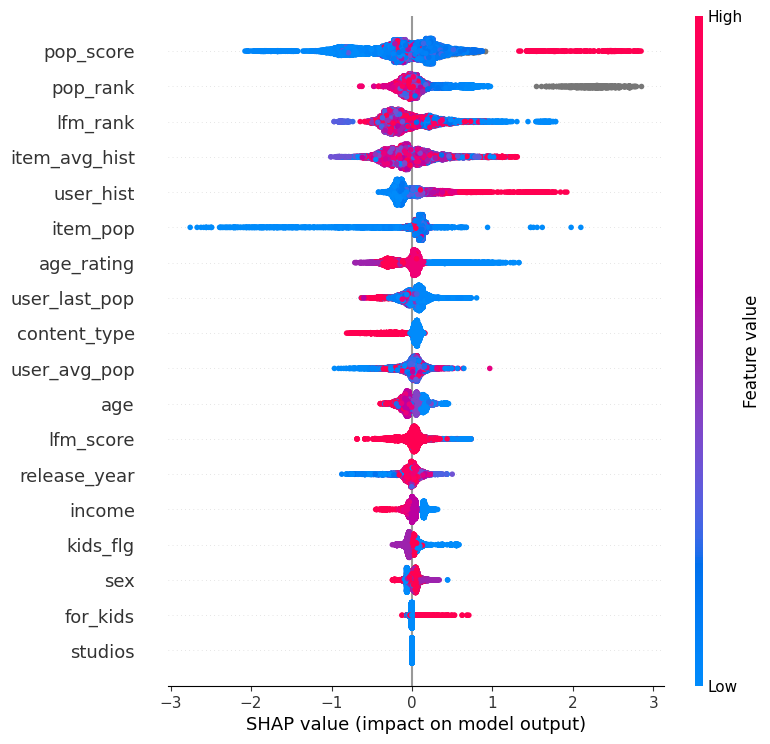

In [29]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

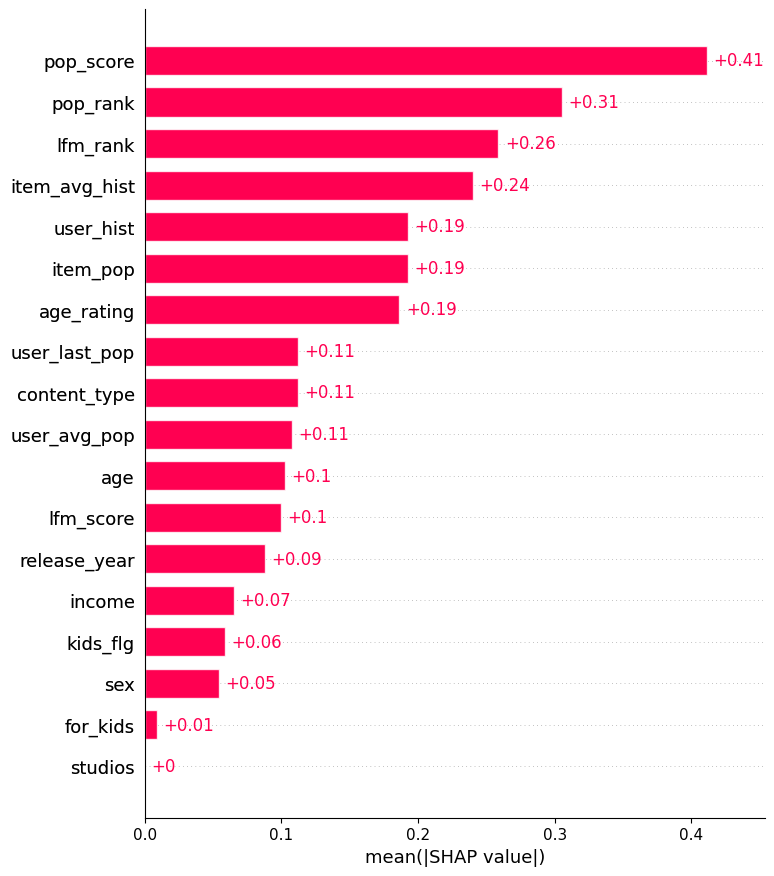

In [30]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

### !!! НАШИ РАНКИ И СКОРЫ круче популярности, прикольно

In [31]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test["target"])

y_pred

array([0.02389251, 0.03229553, 0.01455659, ..., 0.02218346, 0.02216697,
       0.0059566 ])

In [32]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df["lfm_rank"] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df


ranker_test = add_score_and_rank(ranker_test, y_pred, "pointwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
1,1,10440,2021-08-13,19579.0,80.0,-0.010047,102.0,NaN,NaN,1,...,-1,18.0,-1,141889.0,8.068716,1,0.032296,1,-0.000994,101
0,1,3669,2021-08-16,1593.0,26.0,-0.010047,102.0,NaN,NaN,1,...,-1,18.0,-1,2846.0,22.675978,0,0.023893,2,-0.000994,101
2,12,846,2021-08-21,5929.0,18.0,-0.010047,102.0,NaN,NaN,-1,...,0,16.0,-1,528.0,22.799242,0,0.014557,1,-0.000994,101


In [33]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["pointwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.7253359057670802, 0.42950192483011485)

In [42]:
# Получим значения метрик
models_metrics["lfm"] = calc_metrics_(ranker_test, "lfm_rank")
models_metrics["pointwise"] = calc_metrics_(ranker_test, "pointwise_rank")
models_metrics["pointwise_hybrid"] = calc_metrics_(ranker_test, "pointwise_hybrid_rank")

pd.DataFrame(models_metrics)[["lfm", "pointwise", "pointwise_hybrid"]]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.024766,0.247190,0.023551
recall@10,0.082868,0.773721,0.084824
ndcg@10,0.031383,0.326027,0.030071
map@10,0.042232,0.667166,0.044491
novelty@10,3.142818,5.798344,3.396632


### Pairwise/Listwise

In [43]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).


def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(df[["user_id", "item_id"]].groupby(by=["user_id"]).count()["item_id"])

In [44]:
# Добавим таргет посложнее


def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df["target_ranker"] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df["target_ranker"] += (df[Columns.Weight] >= 75).astype(int)
    return df


ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,14,2021-07-01,0.0,0.0,1.258077e-07,88.0,5675.0,74.0,-1,...,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0,0
1,3,24,2021-07-01,0.0,0.0,1.737222e-07,63.0,6676.0,58.0,-1,...,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518,0,0
3,3,101,2021-07-01,0.0,0.0,3.141736e-07,31.0,9542.0,34.0,-1,...,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0


In [45]:
early_stopping_rounds = 32
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg
    "n_estimators": 10000,  # максимальное число деревьев
    "max_depth": 4,  # максимальная глубина дерева
    "num_leaves": 10,  # число листьев << 2^max_depth
    "min_child_samples": 100,  # число примеров в листе
    "learning_rate": 0.25,  # шаг обучения
    "reg_lambda": 1,  # L2 регуляризация
    "colsample_bytree": 0.9,  # доля колонок, которая используется в каждом дереве
    "early_stopping_rounds": early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    "verbose": early_stopping_rounds // 8,  # период вывода метрик
    "random_state": 42,
}
fit_params = {
    "X": ranker_train[cols],
    "y": ranker_train["target_ranker"],
    "group": get_group(ranker_train),
    "eval_set": [(ranker_val[cols], ranker_val["target_ranker"])],
    "eval_group": [get_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10),
    "categorical_feature": cat_cols,
    "feature_name": cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.939462
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.225419
[LightGBM] [Debug] init for col-wise cost 0.094052 seconds, init for row-wise cost 0.307165 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1552
[LightGBM] [Info] Number of data points in the train set: 13520500, number of used features: 18
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
Training 

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [46]:
name_listwise_model = "../models/pickle_data/listwise_model.pickle"
pickle.dump(listwise_model, open(name_listwise_model, "wb"))

In [47]:
listwise_model.best_score_["valid_0"]

OrderedDict([('ndcg@3', 0.6777183684831052),
             ('ndcg@5', 0.7017115676411136),
             ('ndcg@10', 0.7231758811937612)])

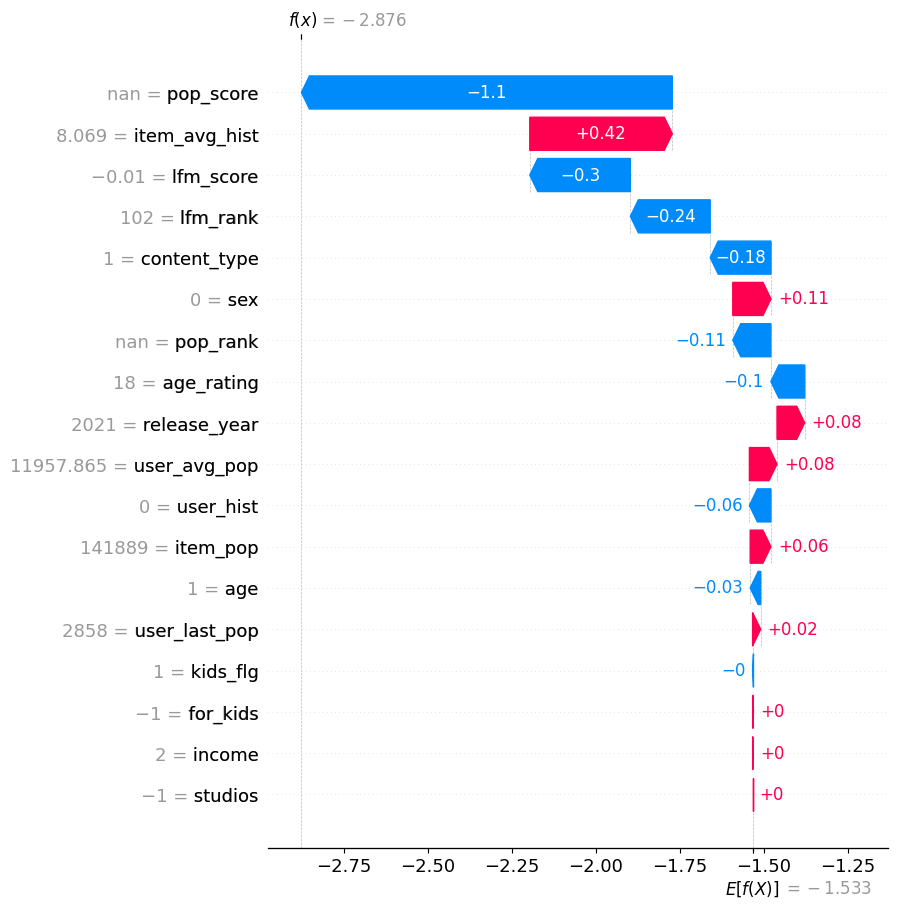

In [48]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

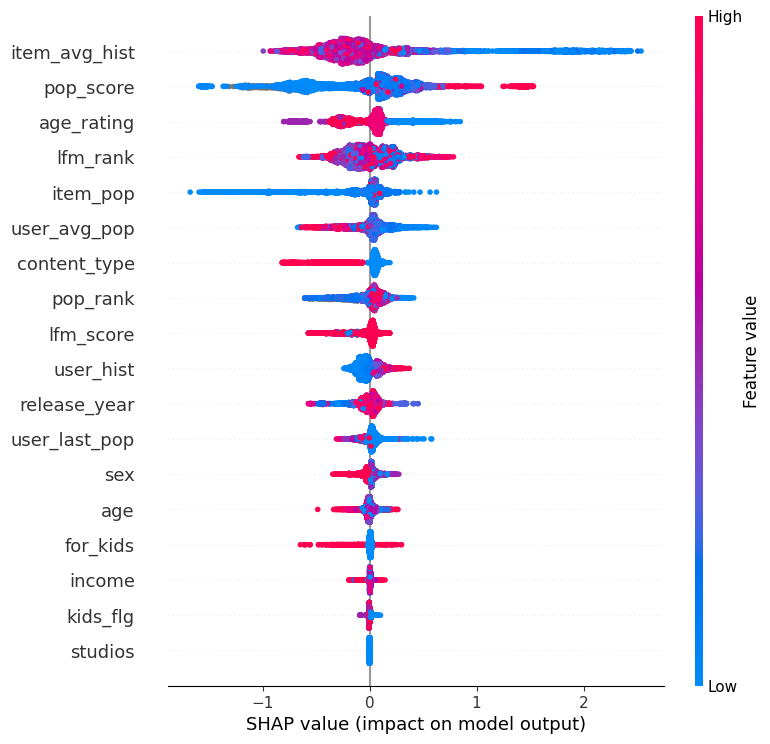

In [49]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

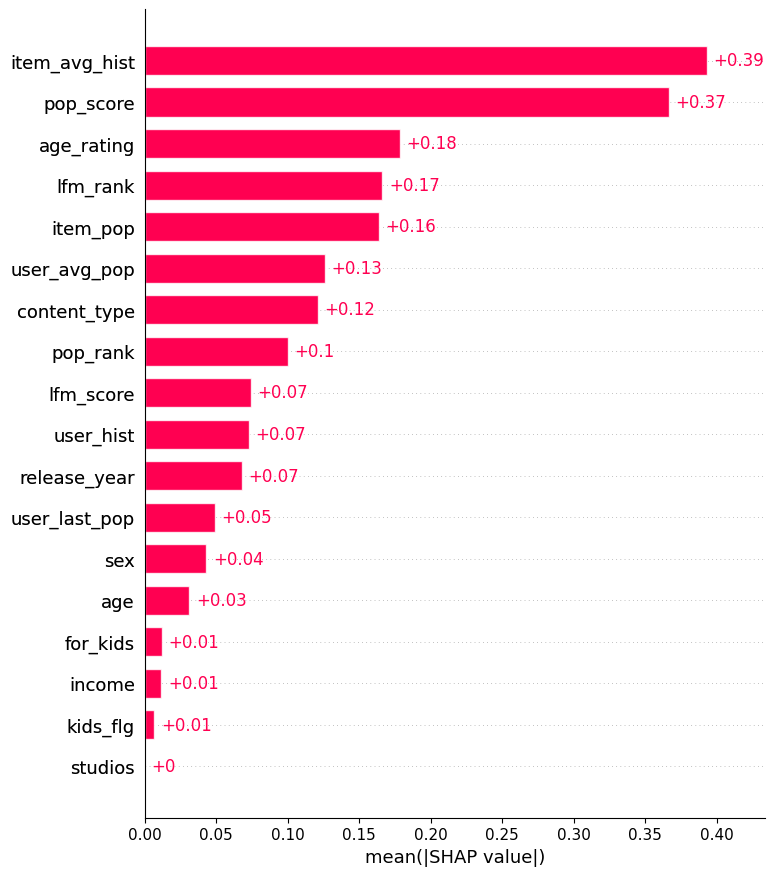

In [50]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [51]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
1,1,10440,2021-08-13,19579.0,80.0,-0.010047,102.0,NaN,NaN,1,...,1,0.032296,1,-0.000994,101,2,-2.875869,1,-7.437457,101
0,1,3669,2021-08-16,1593.0,26.0,-0.010047,102.0,NaN,NaN,1,...,0,0.023893,2,-0.000994,101,1,-3.650820,2,-7.437457,101
2,12,846,2021-08-21,5929.0,18.0,-0.010047,102.0,NaN,NaN,-1,...,0,0.014557,1,-0.000994,101,1,-4.352185,1,-7.437457,101


In [52]:
models_metrics["listwise"] = calc_metrics_(ranker_test, "listwise_rank")
models_metrics["listwise_hybrid"] = calc_metrics_(ranker_test, "listwise_hybrid_rank")
pd.DataFrame(models_metrics)[["listwise", "listwise_hybrid"]]

,listwise,listwise_hybrid
Precision@10,0.187153,0.029563
recall@10,0.643975,0.098200
ndcg@10,0.265026,0.037817
map@10,0.597415,0.051652
novelty@10,5.445856,3.672871


In [53]:
(
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),  # target_ranker
        y_pred=np.array(ranker_test["listwise_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test["target"]),
        y_pred=np.array(ranker_test["listwise_hybrid_score"]),
        user_ids=np.array(ranker_test["user_id"]),
        metric_function=roc_auc_score,
    ),
)

(0.46341639242346266, 0.4290764028168258)

In [54]:
for name in ["train", "val", "test"]:
    path: str = f"../data/ranker_{name}.csv"
    locals()[f"ranker_{name}"].to_csv(path, index=False)

## Итоговые метрики

In [55]:
pd.DataFrame(models_metrics)[["lfm", "pointwise_hybrid", "listwise_hybrid"]]

,lfm,pointwise_hybrid,listwise_hybrid
Precision@10,0.024766,0.023551,0.029563
recall@10,0.082868,0.084824,0.098200
ndcg@10,0.031383,0.030071,0.037817
map@10,0.042232,0.044491,0.051652
novelty@10,3.142818,3.396632,3.672871


__Вывод__ Листвайфс определенно лучше ЛФМ (а вот поинтвайс - кажется нет).

## Итоговые предсказания на прод

Загружаем данные заново

In [2]:
cols = [
    "lfm_score",  ### НАШИ ФИЧИ
    "lfm_rank",  ### НАШИ ФИЧИ
    "pop_score",  ### НАШИ ФИЧИ
    "pop_rank",  ### НАШИ ФИЧИ
    "age",
    "income",
    "sex",
    "kids_flg",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "content_type",
    "release_year",
    "for_kids",
    "age_rating",
    "studios",
    "item_pop",
    "item_avg_hist",
]  # Из них категориальные:
cat_cols = [
    "age",
    "income",
    "sex",
    "kids_flg",
    "content_type",
    "for_kids",
    "studios",
]


def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype("category").cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype("category")
    return df, cat_col_encoding


def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f"{name}_score"] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=["user_id", f"{name}_score"],
        ascending=[True, False],
        inplace=True,
    )
    df[f"{name}_rank"] = df.groupby("user_id").cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df["lfm_rank"] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f"{name}_hybrid_score"] = df[f"{name}_score"] * mask
    df[f"{name}_hybrid_score"].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f"{name}_hybrid_rank"] = df[f"{name}_rank"] * mask
    max_rank: int = 101
    df[f"{name}_hybrid_rank"].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [3]:
for name in ["train", "val", "test"]:
    path: str = f"../data/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [4]:
# без дипкопи, я когда дальше делю на батчи, происходят странные вещи: он обрезает весь датасет
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
ranker_full.shape

(19962023, 33)

In [5]:
ranker_full, _ = encode_cat_cols(ranker_full, cat_cols)

In [6]:
name_listwise_model = "../models/pickle_data/listwise_model.pickle"
listwise_model = pickle.load(open(name_listwise_model, "rb"))

In [7]:
K_RECOS = 10

Будем считать по юзеру, иначе падает по памяти

In [8]:
uids = ranker_full.user_id.unique()
recos = dict()
len(uids)

229366

In [9]:
for uid in tqdm(uids):
    cur_ranker = ranker_full[ranker_full.user_id == uid]
    y_pred: np.ndarray = listwise_model.predict(cur_ranker[cols])
    ranker_full_pred = add_score_and_rank(cur_ranker, y_pred, "listwise")
    recos[uid] = ranker_full_pred.sort_values(["listwise_hybrid_rank"]).head(K_RECOS).item_id.to_list()

  0%|          | 0/229366 [00:00<?, ?it/s]

Пример работы:

In [10]:
recos[3]

[15297, 10440, 16228, 9728, 13865, 12192, 4151, 142, 7829, 5411]

Окей, у нас есть рекомендации, но теперь надо учесть, что LFM мог выдавать меньше 10, присовокупим в таком случае непросмотренное популярное (из того, что еще не выдал рекомендер).

(Похожее делали и в дз-4 по лфм)

Достанем данные, и просмотренное:

In [11]:
# просмотренное пользователями
kion_data = read_kion_dataset(fast_check=1)
interactions = kion_data["interactions"]
data_for_predict = Dataset.construct(interactions.df)

watched = dict(interactions.df[["user_id", "item_id"]].groupby("user_id")["item_id"].agg(list))
watched[0]

[7102, 14359, 15297, 6006, 9728, 12192]

И достанем наш любимый лист популярного:

In [12]:
# всего фильмов
max_k = len(kion_data["items"]["item_id"].unique())

name_popular = "../models/pickle_data/popular.pickle"
loaded_popular = pickle.load(open(name_popular, "rb"))

sample_popular_user = data_for_predict.user_id_map.external_ids[0]
popular_list = list(
    loaded_popular.recommend(dataset=data_for_predict, users=[0], k=max_k, filter_viewed=False)["item_id"]
)
popular_list[:10], len(popular_list)

([10440, 15297, 9728, 13865, 4151, 3734, 2657, 4880, 142, 6809], 15706)

Все это запихнем в класс!

In [13]:
from ranker_lfm_popular import RankerLFMPopular

In [21]:
ranker_lfm_popular = RankerLFMPopular(recos, watched, popular_list)
name_rankerLFM_model = "../models/pickle_data/ranker_model.pickle"
pickle.dump(ranker_lfm_popular, open(name_rankerLFM_model, "wb"))

#### Check

In [22]:
name_rankerLFM_model = "../models/pickle_data/ranker_model.pickle"
ranker_lfm_popular = pickle.load(open(name_rankerLFM_model, "rb"))

In [23]:
ranker_lfm_popular.recommend(3, 10)

[15297, 16228, 13865, 7829, 5411, 6809, 9996, 8636, 4740, 7571]